In ``micrograd``, we stayed on the level of individual scalars. Now we will thing about backprop on the level of tensors. Back in 2012-2014, most people used backpropagation to train networks (another possibility is, e.g., contrastive divergence), but everyone wrote their backward pass manually and used gradient checkers to verify the correctness of their gradients.

In [143]:
import torch
from torch import Tensor
import random
import torch.nn.functional as F

from karpathy_nn.makemore.data.load_data import load_names

import matplotlib.pyplot as plt


In [144]:
random.seed(42)


In [145]:
words = load_names()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [146]:
len(words)


32033

In [147]:
# Build the vocabuilary of tokens and mappings to/from integers
characters = sorted(list(set("".join(words))))
string_to_integer = {string: integer + 1 for integer, string in enumerate(characters)}
string_to_integer["."] = 0
integer_to_string = {integer: string for string, integer in string_to_integer.items()}
num_tokens = len(integer_to_string)
print(integer_to_string)
print(num_tokens)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [148]:
def build_dataset(words: list[str], block_size: int = 3) -> tuple[Tensor, Tensor]:
    # Create the dataset
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + ".":
            idx = string_to_integer[character]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)


The boilerplate is done. Now we get to the action.

In [149]:
# Utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(string: str, dt: Tensor, t: Tensor) -> None:
    exact_equality = torch.all(dt == t.grad).item()
    approximate_equality = torch.allclose(dt, t.grad)
    max_abs_diff = (dt - t.grad).abs().max().item()
    print(
        f"{string:25s} | exact: {str(exact_equality):5s} | approximate: {str(approximate_equality):5s} | max_abs_diff: {max_abs_diff}"
    )


In [150]:
dim_embedding = 10  # Dimensionality of the character embedding vectors
dim_hidden = 64  # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Layer 1
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)
b1 = (
    torch.randn(dim_hidden, generator=g) * 0.1
)  # Using b1 just for fun, it is useless because of batch norm

# Layer 2
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.1
b2 = torch.randn(num_tokens, generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn(1, dim_hidden, generator=g) * 0.1 + 1.0
bn_bias = torch.randn(1, dim_hidden) * 0.1

# Note: We are initializing many of these parameters in non-standard ways
# because sometimes initializing with, e.g., all zeros could mask an
# incorrect implementation of the backward pass.
# (When everything is zero, everything simplifies.)

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True


4137


In [151]:
batch_size = 32
n = batch_size  # A shorter variable name for conveniance
# Construct a minibatch
idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[idx], Ytr[idx]  # Batch X, Y


In [152]:
# Forward pass, chunked into smaller steps that are possible to
# backward through one at a time
# Xb: (32, block_size)
embedding = C[Xb]  # (32, block_size, dim_embedding)
embedding_cat = embedding.flatten(start_dim=1)  # (32, block_size * dim_embedding)

# Linear layer 1
hidden_pre_bn = embedding_cat @ W1 + b1  # (32, dim_hidden)

# BatchNorm layer
bn_mean_i = 1 / n * hidden_pre_bn.sum(dim=0, keepdim=True)  # (1, dim_hidden)
bn_diff = hidden_pre_bn - bn_mean_i  # (32, dim_hidden)
bn_diff2 = bn_diff**2  # (32, dim_hidden)

# Note: Bessel's correction (dividing by n - 1, not n).
# The paper doesn't use Bessel's correction during training,
# but uses it during inference (they multiply the running variance
# by n / (n - 1)). I.e., before storing the variance in the running
# buffer (to be later used in eval mode), the unbiased estimator
# is used, as they multiply by the correction term.
# This introduces a train-test mismatch, where in training they use
# the bias version, but in testing they use the unbiased one.
# Andrej finds this very confusing. One should use the corrected
# version during training as well, as the uncorrected one almost
# always underestimates the true variance. He considers this a bug,
# and the paper doesn't justify this discrepancy. As PyTorch doesn't
# have a flag for that, everyone using BatchNorm has a bug in their code
# in Andrej's opinion. This turns out to be much less of a problem
# when the batch size is larger, but usually it's quite small.
# The PyTorch docs mention that they use the biased estimate, but
# it's actually not true! They do it just as described in the paper.
bn_var = 1 / (n - 1) * bn_diff2.sum(dim=0, keepdim=True)  # (1, dim_hidden)
bn_std_inv = (bn_var + 1e-5) ** -0.5  # (1, dim_hidden)
bn_raw = bn_diff * bn_std_inv  # (32, dim_hidden)
hidden_pre_activation = bn_gain * bn_raw + bn_bias  # (32, dim_hidden)

# Non-linearity
hidden_activation = torch.tanh(hidden_pre_activation)  # Hidden layer

# Linear layer 2
logits = hidden_activation @ W2 + b2  # Output layer

# Cross-entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(dim=1, keepdim=True)[0]
norm_logits = logits - logit_maxes  # Subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)  # (32, 1)

# We use this formulation because something is wrong with the backward
# pass implementation of 1 / x in PyTorch... it gives a weird result
counts_sum_inv = counts_sum**-1  # (32, 1)
probs = counts * counts_sum_inv  # (32, 27) * (32, 1)
log_probs = probs.log()
loss = -log_probs[range(n), Yb].mean()

# PyTorch backward pass
for parameter in parameters:
    parameter.grad = None

# AFAIK, there is no cleaner way
for variable in [
    log_probs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    hidden_activation,
    hidden_pre_activation,
    bn_raw,
    bn_std_inv,
    bn_var,
    bn_diff2,
    bn_diff,
    hidden_pre_bn,
    bn_mean_i,
    embedding_cat,
    embedding,
]:
    variable.retain_grad()
loss.backward()
loss


tensor(3.5975, grad_fn=<NegBackward0>)

Exercise 1: Backprop through the whole computational graph manually, backpropagating through all of the variables as they are defined in the forward pass above, one by one.

In [153]:
dlog_probs = torch.zeros_like(log_probs)  # (32, 27)
dlog_probs[range(n), Yb] = -1 / n  # Others don't influence the loss

# Boosts gradient for samples with very low GT label probabiliy
dprobs = 1 / probs * dlog_probs  # (32, 27)

# Backpropagating through multiplication, then replication.
# Replication: The correct thing during backpropagation is to
# sum the gradients of all outgoing branches to obtain the final
# result.
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)  # (32, 1)

dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv  # (32, 1)

# Both branches are summed up, chain rule solves broadcasting.
# The addition just routes the gradient.
dcounts = counts_sum_inv * dprobs + dcounts_sum  # (32, 27)

dnorm_logits = counts * dcounts  # (32, 27)

# Note: this is zero, because we have seen that an additive constant
# does not change the softmax value and, consequently, the loss.
# It won't be exactly zero because of numerical wonkiness, though.
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdim=True)  # (32, 1)

dlogits = (
    dnorm_logits
    + F.one_hot(logits.max(dim=1)[1], num_classes=logits.shape[1]) * dlogit_maxes
)  # (32, 27)
# dlogits = dnorm_logits
# argmaxes = logits.argmax(dim=1, keepdim=True)
# dlogits[range(n), argmaxes] += dlogit_maxes  # (32, 27)

dhidden_activation = dlogits @ W2.T  # (32, 27) @ (27, dim_hidden) = (32, dim_hidden)

dW2 = hidden_activation.T @ dlogits  # (dim_hidden, 32) @ (32, 27) = (dim_hidden, 27)

db2 = dlogits.sum(dim=0)  # (dim_hidden,)

dhidden_pre_activation = (
    1 - hidden_activation**2
) * dhidden_activation  # (32, dim_hidden)

dbn_gain = (bn_raw * dhidden_pre_activation).sum(dim=0)  # (dim_hidden,)

dbn_bias = dhidden_pre_activation.sum(dim=0)  # (dim_hidden,)

dbn_raw = bn_gain * dhidden_pre_activation  # (32, dim_hidden)

dbn_std_inv = (bn_diff * dbn_raw).sum(dim=0, keepdim=True)  # (1, dim_hidden)

dbn_var = -0.5 * (bn_var + 1e-5) ** (-3 / 2) * dbn_std_inv  # (1, dim_hidden)

dbn_diff2 = 1 / (n - 1) * dbn_var.tile((32, 1))  # (32, dim_hidden)

# Sum different paths
dbn_diff = 2 * bn_diff * dbn_diff2 + bn_std_inv * dbn_raw  # (32, dim_hidden)

dbn_mean_i = -dbn_diff.sum(dim=0, keepdim=True)  # (1, dim_hidden)

dhidden_pre_bn = dbn_diff + 1 / n * dbn_mean_i  # (32, dim_hidden)

dembedding_cat = dhidden_pre_bn @ W1.T
# (32, dim_hidden) @ (dim_hidden, dim_embedding * block_size)
# = (32, dim_embedding * block_size)

dW1 = embedding_cat.T @ dhidden_pre_bn
# (dim_embedding * block_size, 32) @ (32, dim_hidden)
# = dim_embedding * block_size, dim_hidden)

db1 = dhidden_pre_bn.sum(dim=0)  # (dim_hidden,)

dembedding = dembedding_cat.reshape(embedding.shape)  # (32, block_size, dim_embedding)

dC = torch.zeros_like(C)  # (num_tokens, dim_embedding)
for k in range(Xb.shape[0]):  # batch index
    for l in range(Xb.shape[1]):  # context index
        idx = Xb[k, l]
        dC[idx] += dembedding[k, l]  # Accumulate gradients of tokens

cmp("logprobs", dlog_probs, log_probs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("hidden_activation", dhidden_activation, hidden_activation)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hidden_pre_activation", dhidden_pre_activation, hidden_pre_activation)
cmp("bn_gain", dbn_gain, bn_gain)
cmp("bn_bias", dbn_bias, bn_bias)
cmp("bn_raw", dbn_raw, bn_raw)
cmp("bn_std_inv", dbn_std_inv, bn_std_inv)
cmp("bn_var", dbn_var, bn_var)
cmp("bn_diff2", dbn_diff2, bn_diff2)
cmp("bn_diff", dbn_diff, bn_diff)
cmp("bn_mean_i", dbn_mean_i, bn_mean_i)
cmp("hidden_pre_bn", dhidden_pre_bn, hidden_pre_bn)
cmp("embedding_cat", dembedding_cat, embedding_cat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("embedding", dembedding, embedding)
cmp("C", dC, C)


logprobs                  | exact: True  | approximate: True  | max_abs_diff: 0.0
probs                     | exact: True  | approximate: True  | max_abs_diff: 0.0
counts_sum_inv            | exact: True  | approximate: True  | max_abs_diff: 0.0
counts_sum                | exact: True  | approximate: True  | max_abs_diff: 0.0
counts                    | exact: True  | approximate: True  | max_abs_diff: 0.0
norm_logits               | exact: True  | approximate: True  | max_abs_diff: 0.0
logit_maxes               | exact: True  | approximate: True  | max_abs_diff: 0.0
logits                    | exact: True  | approximate: True  | max_abs_diff: 0.0
hidden_activation         | exact: True  | approximate: True  | max_abs_diff: 0.0
W2                        | exact: True  | approximate: True  | max_abs_diff: 0.0
b2                        | exact: True  | approximate: True  | max_abs_diff: 0.0
hidden_pre_activation     | exact: True  | approximate: True  | max_abs_diff: 0.0
bn_gain         

Note: For $D = AB$,
$$\frac{\partial L}{\partial B} = A^\top \frac{\partial L}{\partial D}$$
and
$$\frac{\partial L}{\partial A} = \frac{\partial L}{\partial D} B^\top.$$
(Andrej differentiates through matmul without using this, he never remembers it. He only leverages that shapes have to match up, just like I do. This, of course, fails when the matrices are square.)

It turns out that in the first exercise, we were doing way too much work. It is not what we would do in practice. E.g., when calculating the cross-entropy loss, we broke the calculation up into its most atomic parts and backpropagated through all of those individually. However, if we just look at the mathematical expression of the loss, we can do the differentiation on a paper, and many terms cancel and simplify. The mathematical expression we end up with is significantly shorter and easier to implement than backpropagating through all the little pieces.

Exercise 2: backropagate through cross_entropy but all in one go. To complete this challenge, look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.

In [154]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())


3.5974924564361572 diff: 0.0


We get the "exact" same loss, but it's calculated much faster and takes less time to write. It's also much faster to backprop through this: if we differentiate by hand, we end up with a much shorter expression that runs very fast.

$$
\begin{align*}
\mathcal{L} &= -\frac{1}{n}\sum_{i = 1}^n \log p(y_i \mid x_i)\\
&= -\frac{1}{n} \sum_{i = 1}^n \log \frac{\exp\left(\text{logit}_{i, y_i}\right)}{\sum_{j = 1}^C \exp\left(\text{logit}_{i, j}\right)}\\
&= -\frac{1}{n} \sum_{i = 1}^n \left(\text{logit}_{i, y_i} - \log\sum_{j = 1}^C \exp \left(\text{logit}_{i, j}\right)\right).
\end{align*}
$$
Therefore,
$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial \text{logit}_{k, l}} &= -\frac{1}{n} \sum_{i = 1}^n \left(\delta_{ik}\delta_{y_il} - \frac{\sum_{j = 1}^C \exp\left(\text{logit}_{i, j}\right) \delta_{ik}\delta_{jl}}{\sum_{j = 1}^C \exp\left(\text{logit}_{i, j}\right)}\right)\\
&= -\frac{1}{n}\sum_{i = 1}^n \left(\delta_{ik}\delta_{y_il}-\frac{\exp\left(\text{logit}_{i, l}\right)\delta_{ik}}{\sum_{j = 1}^C \exp\left(\text{logit}_{i, j}\right)}\right)\\
&= -\frac{1}{n} \left(\delta_{y_kl} - \frac{\exp\left(\text{logit}_{k, l}\right)}{\sum_{j = 1}^C \exp\left(\text{logit}_{k, j}\right)}\right)\\
&= \frac{1}{n}\left(\text{softmax}_{k, l} - \text{onehot}_{k, l}\right).
\end{align*}
$$

In [155]:
# Backward pass
dlogits = 1 / n * (probs - F.one_hot(Yb, num_classes=logits.shape[1]))

# dlogits = F.softmax(logits, dim=1)
# dlogits[range(n), Yb] -= 1
# dlogits /= n

cmp("logits", dlogits, logits)  # Andrej gets the same result


logits                    | exact: False | approximate: True  | max_abs_diff: 6.05359673500061e-09


We have some floating point wonkiness, but we basically get the correct answer.

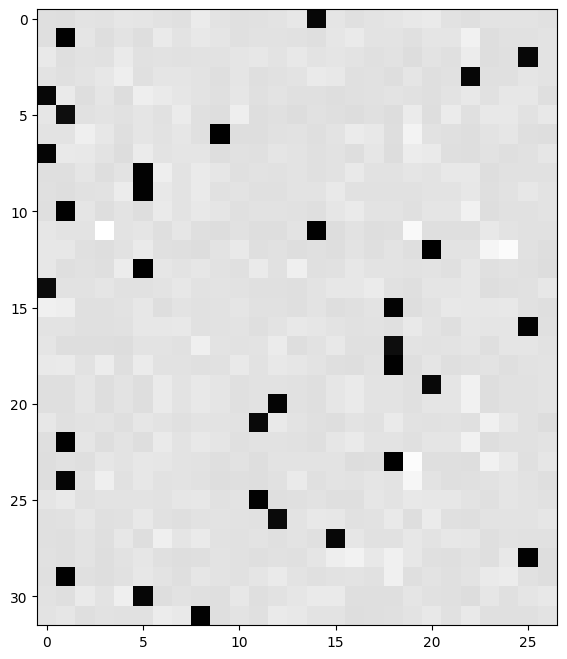

In [156]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap="gray")


In [157]:
probs[0]


tensor([0.0182, 0.0116, 0.0343, 0.0327, 0.0500, 0.0450, 0.0310, 0.0246, 0.0716,
        0.0350, 0.0222, 0.0254, 0.0380, 0.0562, 0.0424, 0.0464, 0.0213, 0.0406,
        0.0439, 0.0571, 0.0661, 0.0300, 0.0173, 0.0346, 0.0396, 0.0377, 0.0272],
       grad_fn=<SelectBackward0>)

In [158]:
dlogits[0] * n


tensor([ 0.0182,  0.0116,  0.0343,  0.0327,  0.0500,  0.0450,  0.0310,  0.0246,
         0.0716,  0.0350,  0.0222,  0.0254,  0.0380,  0.0562, -0.9576,  0.0464,
         0.0213,  0.0406,  0.0439,  0.0571,  0.0661,  0.0300,  0.0173,  0.0346,
         0.0396,  0.0377,  0.0272], grad_fn=<MulBackward0>)

In [159]:
dlogits[0].sum()


tensor(-6.0536e-09, grad_fn=<SumBackward0>)

``dlogits`` rows sum to zero. Each gradient value in each row is like a force: we are pulling down on the probabilities of the incorrect characters, and we are pulling up the probability of the GT character. (Increasing the GT prob a tiny bit will decrease the loss quite a lot. Increasing any other probability increases the loss.) The amount of push and pull is equalized because the sum is zero. If our predicted probabilities were perfect, we would have 0 gradient, as it should be. The lower our GT prediction is, the more force we apply at the GT label location to increase that probability. The higher the probability is at incorrect indices, the more force we apply to pull it down.

Exercise 3: Backpropagate through batch norm but all in one go. To complete this challenge, look at the mathematical expression of the output of batch norm, take the derivative wrt. its input, simplify the expression, and just write it out.

In [160]:
# Forward pass:
hidden_pre_activation_fast = (
    bn_gain
    * (hidden_pre_bn - hidden_pre_bn.mean(dim=0, keepdim=True))
    / torch.sqrt(hidden_pre_bn.var(dim=0, keepdim=True, unbiased=True) + 1e-5)
    + bn_bias
)
print("Max diff:", (hidden_pre_activation - hidden_pre_activation_fast).abs().max())


Max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


Calculate ``dhidden_pre_bn`` given ``dhidden_pre_activation``, i.e., backpropagate through the batchnorm. You will also need to use some of the variables from the forward pass up above.

In [161]:
hidden_pre_bn.shape


torch.Size([32, 64])

1. $\mu = \frac{1}{n}\sum_{i = 1}^n x_i$

2. $\sigma^2 = \frac{1}{n - 1} \sum_{i = 1}^n (x_i - \mu)^2$

3. $\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$

4. $y_i = \gamma \hat{x}_i + \beta$

We know that
$$\frac{dL}{dx_i} =  \sum_{j = 1}^n \frac{dL}{dy_j} \cdot \frac{dy_j}{dx_i}.$$
Here we assume that we already know the value of $\frac{dL}{dy_j}$ from backprop, so we only have to calculate $\frac{dy_j}{dx_i}$.
$$
\begin{align*}
\frac{dy_j}{dx_i} &= \frac{\partial y_j}{\partial \hat{x}_j} \cdot \frac{\partial \hat{x}_j}{\partial \mu} \cdot \frac{\partial \mu}{\partial x_i} + \frac{\partial y_j}{\partial \hat{x}_j} \cdot \frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial x_i} + \frac{\partial y_i}{\partial \hat{x}_j} \cdot \frac{\partial \hat{x}_j}{\partial x_i}\\
&= \gamma \left(\frac{\partial \hat{x}_j}{\partial \mu} \cdot \frac{\partial \mu}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial x_i}\right)
\end{align*}
$$
Let's calculate the terms in the paranthesis.
$$
\begin{align*}
\frac{\partial \hat{x}_j}{\partial \mu} \cdot \frac{\partial \mu}{\partial x_i} &= -\frac{1}{\sqrt{\sigma^2 + \epsilon}} \cdot \frac{1}{n}\\
\frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial x_i} &= -\frac{1}{2}(x_j - \mu)(\sigma^2 + \epsilon)^{-3/2} \cdot \frac{2}{n - 1}\sum_{j = 1}^n (x_j - \mu) \cdot \delta_{ij}\\
&= -\frac{1}{2}(x_j - \mu)(\sigma^2 + \epsilon)^{-3/2} \cdot \frac{2}{n - 1}(x_i - \mu)\\
\frac{\partial \hat{x}_j}{\partial x_i} &= \frac{1}{\sqrt{\sigma^2 + \epsilon}}\cdot \delta_{ij}
\end{align*}
$$
Substituting in, we get
$$
\begin{align*}
\frac{dy_j}{dx_i} &= \gamma\left(-\frac{1}{\sqrt{\sigma^2 + \epsilon}}\cdot \frac{1}{n} - \frac{1}{2} (x_j - \mu)(\sigma^2 + \epsilon)^{-3/2} \cdot \frac{2}{n - 1}(x_i - \mu) + \frac{1}{\sqrt{\sigma^2 + \epsilon}}\delta_{ij}\right)\\
&= \gamma\left(-\frac{1}{n}\frac{1}{\sqrt{\sigma^2 + \epsilon}} - \frac{1}{n - 1}\frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \frac{1}{\sqrt{\sigma^2 + \epsilon}}\delta_{ij}\right).
\end{align*}
$$
Finally, we have
$$
\begin{align*}
\frac{dL}{dx_i} &= \sum_{j = 1}^n \frac{dL}{dy_j} \cdot \gamma\left(-\frac{1}{n}\frac{1}{\sqrt{\sigma^2 + \epsilon}} - \frac{1}{n - 1}\frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \frac{1}{\sqrt{\sigma^2 + \epsilon}}\delta_{ij}\right)\\
&= -\frac{1}{n} \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}} \left(\sum_{j = 1}^n \frac{dL}{dy_j} + \frac{n}{n - 1} \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \sum_{j = 1}^n \frac{dL}{dy_j} \frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}} - n\frac{dL}{dy_i}\right)\\
&= \frac{\gamma (\sigma^2 + \epsilon)^{-1/2}}{n} \left(n\frac{dL}{dy_i} - \sum_{j = 1}^n \frac{dL}{dy_j} - \frac{n}{n - 1} \hat{x}_i \sum_{j = 1}^n \frac{dL}{dy_j}\hat{x}_j\right)
\end{align*}
$$

In [162]:
dhidden_pre_bn = (
    bn_gain  # (1, dim_hidden)
    * bn_std_inv  # (1, dim_hidden)
    / n  # ()
    * (
        n * dhidden_pre_activation  # (32, dim_hidden)
        - dhidden_pre_activation.sum(dim=0)  # (dim_hidden,)
        - n
        / (n - 1)
        * bn_raw
        * (dhidden_pre_activation * bn_raw).sum(dim=0)  # (32, dim_hidden)
    )
)  # (32, dim_hidden)

cmp("hidden_pre_bn", dhidden_pre_bn, hidden_pre_bn)


hidden_pre_bn             | exact: False | approximate: True  | max_abs_diff: 9.313225746154785e-10


Exercise 4: putting it all together. Train the MLP neural net with your own backward pass.

In [163]:
# Initialization
dim_embedding = 10  # Dimensionality of the character embedding vectors
dim_hidden = 200  # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Layer 1
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)
b1 = torch.randn(dim_hidden, generator=g) * 0.1

# Layer 2
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.1
b2 = torch.randn(num_tokens, generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn(1, dim_hidden) * 0.1 + 1
bn_bias = torch.randn(1, dim_hidden) * 0.1

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters

# Same optimization as in the last notebook
max_steps = 200000
batch_size = 32
n = batch_size  # For convenience
loss_i = []

# Optimization
for i in range(max_steps):
    # Construct mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]  # Batch X, Y

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the contex

    # Linear layer
    hidden_pre_bn = embedding_cat @ W1 + b1

    # BatchNorm layer
    bn_mean = hidden_pre_bn.mean(dim=0, keepdim=True)
    bn_var = hidden_pre_bn.var(dim=0, keepdim=True, unbiased=True)
    bn_std_inv = (bn_var + 1e-5) ** -0.5
    bn_raw = (hidden_pre_bn - bn_mean) * bn_std_inv
    hidden_pre_activation = bn_gain * bn_raw + bn_bias

    # Non-linearity
    hidden_activation = torch.tanh(hidden_pre_activation)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass -- manual backprop!  # swole_doge_meme
    dlogits = 1 / n * (F.softmax(logits, dim=1) - F.one_hot(Yb, num_classes=logits.shape[1]))

    dhidden_activation = (
        dlogits @ W2.T
    )  # (32, 27) @ (27, dim_hidden) = (32, dim_hidden)

    dW2 = (
        hidden_activation.T @ dlogits
    )  # (dim_hidden, 32) @ (32, 27) = (dim_hidden, 27)

    db2 = dlogits.sum(dim=0)  # (dim_hidden,)

    dhidden_pre_activation = (
        1 - hidden_activation**2
    ) * dhidden_activation  # (32, dim_hidden)

    dhidden_pre_bn = (
        bn_gain  # (1, dim_hidden)
        * bn_std_inv  # (1, dim_hidden)
        / n  # ()
        * (
            n * dhidden_pre_activation  # (32, dim_hidden)
            - dhidden_pre_activation.sum(dim=0)  # (dim_hidden,)
            - n
            / (n - 1)
            * bn_raw
            * (dhidden_pre_activation * bn_raw).sum(dim=0)  # (32, dim_hidden)
        )
    )  # (32, dim_hidden)

    dbn_gain = (bn_raw * dhidden_pre_activation).sum(dim=0)  # (dim_hidden,)

    dbn_bias = dhidden_pre_activation.sum(dim=0)  # (dim_hidden,)

    dembedding_cat = dhidden_pre_bn @ W1.T
    # (32, dim_hidden) @ (dim_hidden, dim_embedding * block_size)
    # = (32, dim_embedding * block_size)

    dW1 = embedding_cat.T @ dhidden_pre_bn
    # (dim_embedding * block_size, 32) @ (32, dim_hidden)
    # = dim_embedding * block_size, dim_hidden)

    db1 = dhidden_pre_bn.sum(dim=0)  # (dim_hidden,)

    dembedding = dembedding_cat.reshape(
        embedding.shape
    )  # (32, block_size, dim_embedding)

    dC = torch.zeros_like(C)  # (num_tokens, dim_embedding)
    for k in range(Xb.shape[0]):  # batch index
        for l in range(Xb.shape[1]):  # context index
            idx = Xb[k, l]
            dC[idx] += dembedding[k, l]  # Accumulate gradients of tokens

    grads = [dC, dW1, db1, dW2, db2, dbn_gain, dbn_bias]

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter, grad in zip(parameters, grads):
        parameter.data -= learning_rate * grad  # New way of swole doge
    
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())


12297
      0/ 200000: 3.7895
  10000/ 200000: 2.1728
  20000/ 200000: 2.4086
  30000/ 200000: 2.4734
  40000/ 200000: 1.9639
  50000/ 200000: 2.3418
  60000/ 200000: 2.4618
  70000/ 200000: 2.0952
  80000/ 200000: 2.3559
  90000/ 200000: 2.1882
 100000/ 200000: 1.8809
 110000/ 200000: 2.3082
 120000/ 200000: 1.9443
 130000/ 200000: 2.4713
 140000/ 200000: 2.2350
 150000/ 200000: 2.1873
 160000/ 200000: 1.9379
 170000/ 200000: 1.8704
 180000/ 200000: 2.0474
 190000/ 200000: 1.9184


In [164]:
# Calibrate the batch norm at the end of training

# Pass the training set through
embedding = C[Xtr]
embedding_cat = embedding.flatten(start_dim=1)
hidden_pre_activation = embedding_cat @ W1 + b1
# Measure the mean / std over the entire training set
bn_mean = hidden_pre_activation.mean(dim=0, keepdim=True)
bn_var = hidden_pre_activation.var(dim=0, keepdim=True, unbiased=True)

# Evaluate train and val loss
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_pre_activation = bn_gain * (hidden_pre_activation - bn_mean) * (bn_var + 1e-5)**-0.5 + bn_bias
    hidden_activation = torch.tanh(hidden_pre_activation)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0714423656463623
val 2.1101531982421875


This is basically the same result we obtained previously with ``.backward()``, but now we don't track any gradients automatically. We wrote backpropagation manually, and it works well! Let's sample from the model.

In [165]:
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    context = [0] * block_size  # Initialize with all ...
    while True:
        # Forward pass
        embedding = C[context]  # (block_size, dim_embedding)
        embedding_cat = embedding.flatten()  # (block_size * dim_embedding)
        hidden_pre_activation = embedding_cat @ W1 + b1
        hidden_pre_activation = bn_gain * (hidden_pre_activation - bn_mean) * (bn_var + 1e-5)**-0.5 + bn_bias
        hidden_activation = torch.tanh(hidden_pre_activation)  # (dim_hidden,)
        logits = hidden_activation @ W2 + b2  # (vocab_size,)

        # Sample
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]

        if idx == 0:
            break

        out.append(idx)
    
    print("".join(integer_to_string[i] for i in out))


carlah
amille
khyimrix
taty
skaessa
jazonte
delynn
jareeigh
kasia
chaily
kaleigh
ham
joce
quint
shoine
liven
corterra
jarynix
kaellinsley
dae


That's a wrap!